# Modellen evalueren en verbeteren 
### K. Verbeeck, T. Vermeulen, J. Maervoet
Data Science (Theory) -- OGI02i

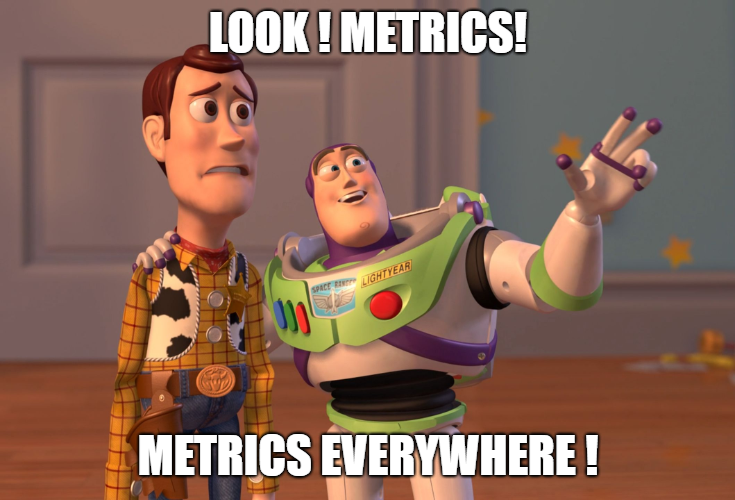

### Cross-validation

De typische manier totnogtoe om een model te evalueren is door gebruik te maken van de **train\_test\_split** methode, daarna met de trainingsdata een model op te stellen via de **_fit_** methode, vervolgens de **_predict_** methode te gebruiken op de test set en tenslotte via de **_score_** methode na te gaan wat de **_accuracy_** is op de test set.

In [19]:
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# create a synthetic dataset
X, y = make_blobs(random_state=0)

# split data and labels into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# instantiate a model and fit it to the training set
logreg = LogisticRegression(solver='liblinear', multi_class='auto').fit(X_train, y_train)

# evaluate the model on the test set
print("Test set score: {:.2f}".format(logreg.score(X_test, y_test)))

Test set score: 0.88


Het doel is om te achterhalen hoe goed we data kunnnen voorspellen die niet aanwezig is in de trainingsdata. 
De fit op de trainingsdata zelf is dus eigenlijk niet zo belangrijk. Wel het **generalizatie vermogen** van het model. 
We kunnen dit op 2 verschillende manieren verbeteren :

  **Cross-validatie** : de test set wordt op een meer robuuste manier gekozen
    
  **Grid-search** : een effectieve methode om parameters goed te leren instellen


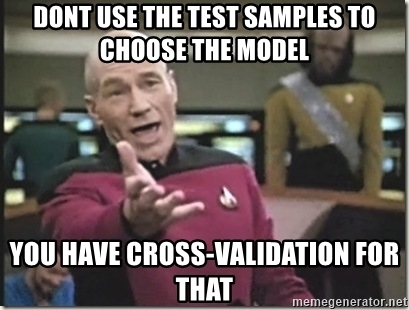

#### Cross-validatie

Tijdens cross-validatie wordt de data meerdere keren gesplit en worden er dus ook meerdere modellen getrained.
Typisch wordt **k-fold cross-validatie** gebruikt waarbij $\bf{k}$ de parameters is die aangeeft in hoeveel gelijke delen (**folds genaamd**) de data wordt opgesplitst. Vervolgens worden $\bf{k}$ modellen getraind : het eerste model gebruikt de eerste fold als test-set en al de rest als trainingsset, het tweede model gebruikt de tweede fold als testset en de rest als trainingsset enz..

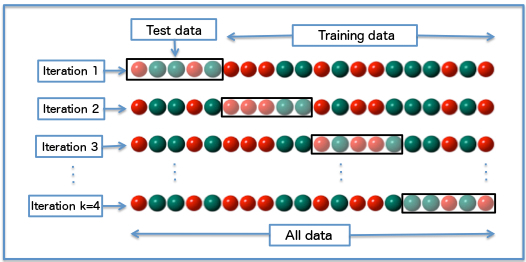






#### Cross-Validatie in scikit-learn



In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

iris = load_iris()
logreg = LogisticRegression(solver='liblinear', multi_class='auto')

scores = cross_val_score(logreg, iris.data, iris.target, cv = 3)
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.96078431 0.92156863 0.95833333]


In [21]:
scores = cross_val_score(logreg, iris.data, iris.target)
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.96078431 0.92156863 0.95833333]


C:\Users\katja.verbeeck\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [22]:
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Average cross-validation score: 0.95


In [23]:
from sklearn.model_selection import cross_validate
res = cross_validate(logreg, iris.data, iris.target, cv=5,
                     return_train_score=True)
display(res)

{'fit_time': array([0.0019989 , 0.00098348, 0.00199962, 0.00199962, 0.00099778]),
 'score_time': array([0.        , 0.00100589, 0.        , 0.00101328, 0.00099921]),
 'test_score': array([1.        , 0.96666667, 0.93333333, 0.9       , 1.        ]),
 'train_score': array([0.95      , 0.96666667, 0.96666667, 0.975     , 0.95833333])}

In [24]:
import pandas as pd
res_df = pd.DataFrame(res)
display(res_df)
print("Mean times and scores:\n", res_df.mean())

,fit_time,score_time,test_score,train_score
0,0.001999,0.000000,1.000000,0.950000
1,0.000983,0.001006,0.966667,0.966667
2,0.002000,0.000000,0.933333,0.966667
3,0.002000,0.001013,0.900000,0.975000
4,0.000998,0.000999,1.000000,0.958333


Mean times and scores:
 fit_time       0.001596
score_time     0.000604
test_score     0.960000
train_score    0.963333
dtype: float64


Er is een variantie in accuracy tussen de verschillende folds : sommige folds halen $100%$, andere $90%$. 
    Dit kan 2 dingen betekenen:
        - het model is sterk afhankelijk van de geselecteerde fold
        - dit voorbeeld bevat te weinig data
        

#### Overzicht Cross-validatie :

- elk datapunt komt exact 1 keer in een test set terecht, waardoor je het model oplegt om te **generalizeren over elk 
datapunt** !
Wanneer je randomness gebruikt om een testset samen te stellen, kan het zijn dat net je moeilijke voorbeelden 
in de testset terecht komen waardoor de accuracy waarschijnlijk te laag ingeschat wordt. 
In het omgekeerde geval, kunnen alle makkelijke datapunten in de testset terecht komen, 
je accuracy wordt waarschijnlijk veel te hoog ingeschat!


- door de verschillende accuracies op de verschillende folds te zien kan je inschatten wat je **best-case prestatie** zou kunnen zijn en wat je **worst-case scenario** is.


- Door meerdere folds te kiezen kan typisch ook **meer data gebruikt worden om het model op te stellen**. 
   - Stel : gewone split $25%$ versus $70%$ -> $70%$ van de data wordt gebruikt om het model te bouwen. 
   - Stel $k=5$ -> $\frac{4}{5}$de = $ 80%$ van de data kan gebruikt worden om het model te bouwen.
   - Stel $k=10$ -> $\frac{9}{10}$de = $ 90%$ van de data kan gebruikt worden om het model te bouwen.
 
 
- Natuurlijk, meer modellen trainen vraagt **meer rekenkracht** !


- Merk op : Cross-validatie dient om een model **beter/realistischer te evalueren**, de techniek op zich geeft geen model als resultaat terug !


#### Stratified Cross-validatie

Merk op : in het geval van classificatie :

Bij het opdelen van de datasets in folds kan je best rekening houden met hoe de verschillende 
klassen verspreid zijn over de data. Een fold met alleen voorbeelden uit 1 klasse is geen nuttige 
testset, en dus ook geen nuttige fold!

In [25]:
from sklearn.datasets import load_iris
iris = load_iris()
print("Iris labels:\n{}".format(iris.target))

Iris labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


Stel dat er hier 3 folds gemaakt worden, met per fold telkens de data van 1 klasse ???

-> zorg ervoor dat per fold alle klassen gelijkwaardig verdeeld zijn, dit noemt men **Stratified cross-validation**

#### Stratified Cross-validation

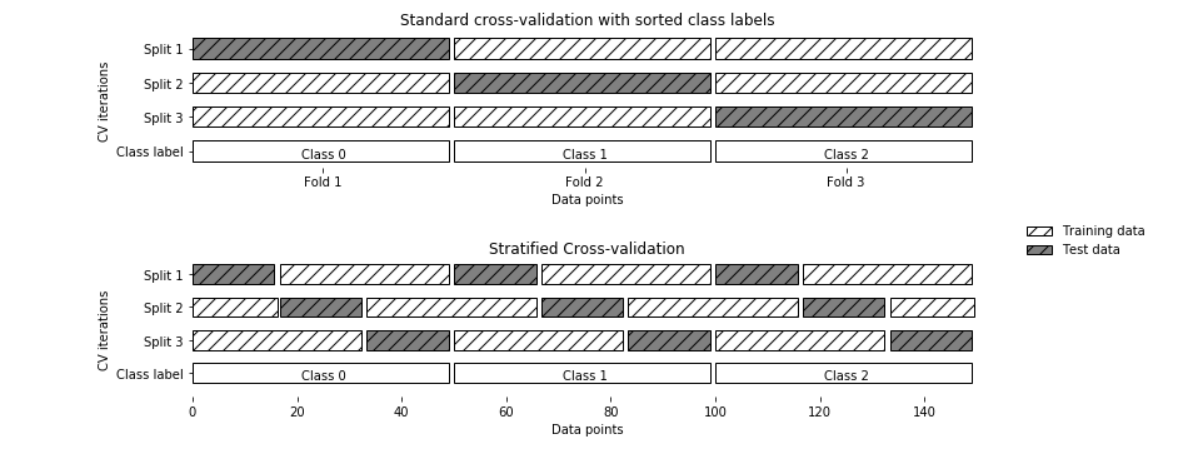

Uit de documentatie van de cv parameter :  **sklearn.model_selection.cross_val_score** :
>cv : int, cross-validation generator or an iterable, optional
Determines the cross-validation splitting strategy. Possible inputs for cv are:
    - None, to use the default 3-fold cross validation (zie warning hierboven, wordt gewijzigd naar 5),
    - integer, to specify the number of folds in a (Stratified)KFold,
    - CV splitter,
    - An iterable yielding (train, test) splits as arrays of indices.
For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. In all other cases, KFold is used.

Er is echter ook een _shuffle_ parameter !
    

In [26]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=3)
print("Cross-validation scores:\n{}".format(
    cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

Cross-validation scores:
[0. 0. 0.]


In [27]:
kfold = KFold(n_splits=3, shuffle=True, random_state=0)
print("Cross-validation scores:\n{}".format(
    cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

Cross-validation scores:
[0.9  0.96 0.96]


#### Leave-one-out cross validation

Beschouw het extreme geval waarbij $k = \; de \; grootte \; van \; de \; dataset$. Elke fold bevat dan exact 1 data element. Deze techniek heet **leave-one-out cross validation**, deze is uiteraard time-consuming maar vooral interessant voor kleine datasets.

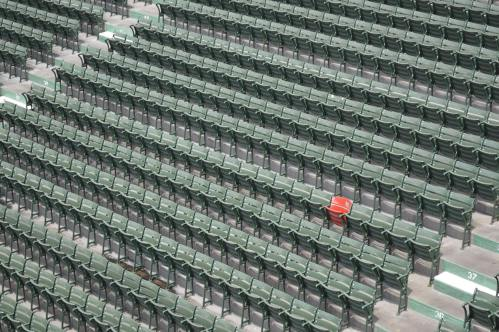

#### GroupKFold


Het zou kunnen dat los van de klassen er nog een andere groepsindeling in de data gemaakt kan worden, bvb. :
    - speech recognition : je hebt meerdere recordings van dezelfde stem in je data
    - beeldherkenning : je hebt meerdere fotos van dezelfde persoon in je data
    - medische applicaties : je hebt meerdere samples van dezelfde patient.
    
GroupKfold zal ervoor zorgen dat de groep samen blijft en dus ofwel integraal in de training of in de test zit, merk op dit heeft niets te maken met de klaslabels.

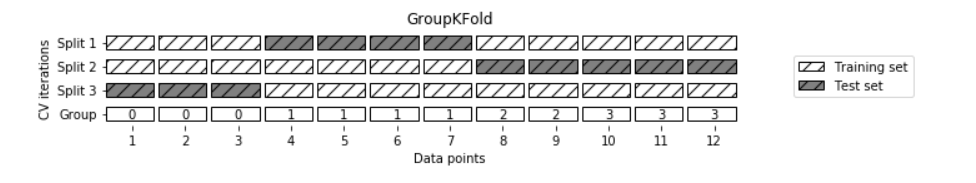

### Grid Search

**Doel** : Zoek de betere waarden van de parameters van een model zodat ze optimaal generalizeren.

**Voorbeeld** : Elbow methode, evalueer de waarde van parameter $k$ op de test-set

**Gevaar** : Als de testset gebruikt wordt om de parameters te leren instellen, kunnen we diezelfde set dan nog gebruiken om te evalueren hoe goed het model generalizeert? (want de parameters zijn al getuned voor deze set en er bestaat gevaar op **overfitting op de testset**)

**Oplossing** : We hebben nog een derde onafhankelijke set van data nodig eentje die specifiek gebruikt kan worden om de parameter tuning te doen : deze set noemen we de **validatie set**

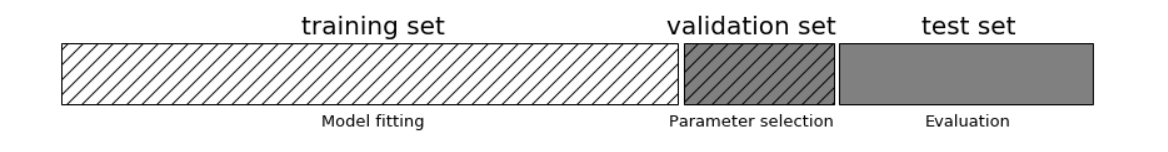




In [28]:
from sklearn.model_selection import train_test_split 

# split data into train+validation set and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(iris.data, iris.target, random_state=0)

# split train+validation set into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=1)

print("Size of training set: {}   size of validation set: {}   size of test set:"
      " {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

best_score = 0


Size of training set: 84   size of validation set: 28   size of test set: 38



In [29]:
from sklearn.tree import DecisionTreeClassifier

# make a grid for parameter tuning
for depth in [1,2,3,4,5]:
    for rs in [0,5,10,20,40]:
    # for each combination of parameters train a decisiontree
        tree = DecisionTreeClassifier(max_depth=depth, random_state=rs)
        tree.fit(X_train, y_train)
        # evaluate for the validation set
        score = tree.score(X_valid, y_valid)
        # store the best scores
        if score > best_score:
            best_score = score
            best_parameters = {'max_depth': depth, 'random_state': rs}

print("Best parameters: ", best_parameters)

Best parameters:  {'max_depth': 3, 'random_state': 0}


In [30]:
# rebuild a model on the combined training and validation set,
# and evaluate it on the test set
tree = DecisionTreeClassifier(**best_parameters)
tree.fit(X_trainval, y_trainval)
training_score = tree.score(X_train, y_train)
test_score = tree.score(X_test, y_test)

print("Training set score with best parameters : {:.2f}".format(training_score))
print("Best score on validation set: {:.2f}".format(best_score))
print("Test set score with best parameters: {:.2f}".format(test_score))

Training set score with best parameters : 1.00
Best score on validation set: 0.93
Test set score with best parameters: 0.97


#### Grid search in combinatie met Cross-validatie

Cross-validatie wordt vaak gebruikt in combinatie met grid search, 
men verwijst vaak gewoon naar de term cross-validatie om beide technieken samen aan te duiden :
in plaats van een enkele split te maken tussen training en validatie set, wordt hier cross-validatie gebruikt

In [32]:
# make a grid for parameter tuning
for depth in [1,2,3,4,5]:
    for rs in [0,5,10,20,40]:
    # for each combination of parameters train a decisiontree
        tree = DecisionTreeClassifier(max_depth=depth, random_state=rs)
        # Extra step : perform cross-validation here (trainval will be split in training en validation several times)
        scores = cross_val_score(tree, X_trainval, y_trainval, cv = 5)
        # compute mean cross-validation accuracy
        score = scores.mean()
        # store the best scores
        if score > best_score:
            best_score = score
            best_parameters = {'max_depth': depth, 'random_state': rs}

print("Best parameters: ", best_parameters)

Best parameters:  {'max_depth': 4, 'random_state': 0}


In [33]:
tree = DecisionTreeClassifier(**best_parameters)
tree.fit(X_trainval, y_trainval)
training_score = tree.score(X_trainval, y_trainval)
test_score = tree.score(X_test, y_test)

print("Training set score with best parameters : {:.2f}".format(training_score))
print("Best score on validation set: {:.2f}".format(best_score))
print("Test set score with best parameters: {:.2f}".format(test_score))

Training set score with best parameters : 1.00
Best score on validation set: 0.95
Test set score with best parameters: 0.97


### Overzicht :
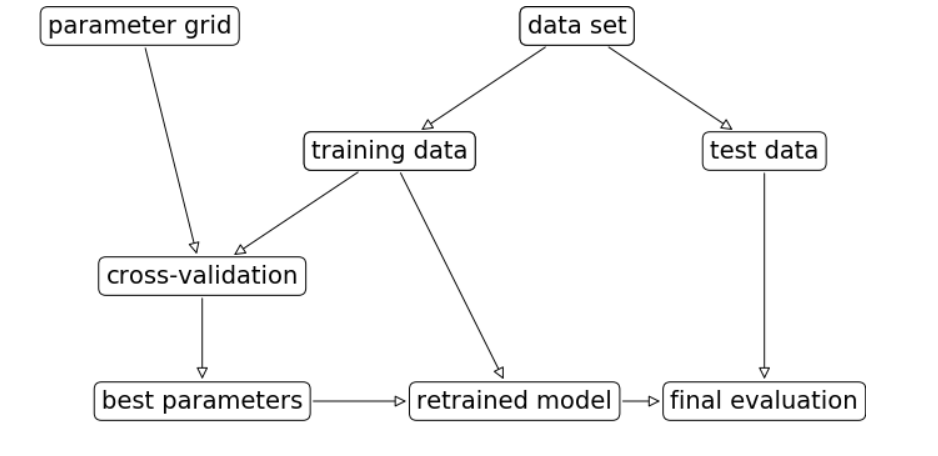

De combinatie van Grid search met CV is zo populair dat sklearn een aparte klasse **GridSearchCV** voorziet

In [34]:
param_grid = {'max_depth': [1,2,3,4,5],
              'random_state': [0,5,10,20,40]}
print("Parameter grid:\n{}".format(param_grid))

Parameter grid:
{'max_depth': [1, 2, 3, 4, 5], 'random_state': [0, 5, 10, 20, 40]}


In [36]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5,
                          return_train_score=True)
# do not overfit the parameters !
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)
grid_search.fit(X_train, y_train)
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Test set score: 0.97
Best parameters: {'max_depth': 4, 'random_state': 0}
Best cross-validation score: 0.95
Best estimator:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')


#### Visualisatie van de GridSearchCV aan de hand van een heat map

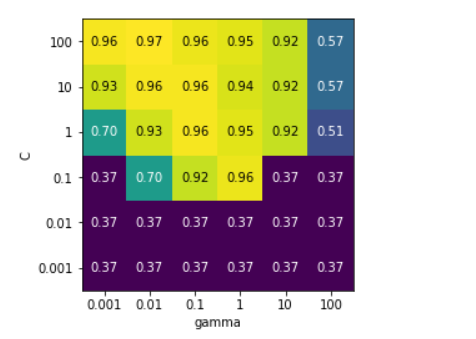

Merk op : Al deze modellen uitrekenen is rekenintensief ! De grid moet m.a.w. goed gekozen worden.

### Metrieken om beter te evalueren

metrieken gebruikt tot dusver :

- voor classificatie : **accuracy** : tel het aantal juist geclassificeerde data-elementen in de testset tov de grootte van de testset

- voor regressie : **MSE** : mean-squared-error : bereken het verschil tussen voorspelde en werkelijke waarde, kwadrateer deze fouten en neem hier een gemiddelde van

Er zijn echter nog veel metrieken die gebruikt kunnen worden en beter geschikt zijn afhankelijk van de applicatie.

### Metrieken voor binaire classificatie

We spreken hier meestal over een $positieve$ versus een $negatieve$ klasse.

Zijn we alleen geïnteresseerd in het aantal fouten (= accuracy) dat het geleerd model maakt?

###### Sommige fouten kunnen erger zijn dan andere  : 

Bvb. een zieke patiënt die toch als gezond geclassificeerd wordt is een grotere fout dan een gezonde patiënt die doorverwezen wordt naar extra testen omdat hij foutief als ziek geclassificeerd wordt. M.a.w de **vals positieven** zijn minder erg dan de **vals negatieven** in dit geval ! 

Een reële (business) targetfunctie zou kunnen zijn : minimaliseer het aantal overlijdens.
Het meten van de accuracy zal hier dan geen goede evaluator zijn voor deze target. Eerder moet het aantal vals negatieven geminimaliseerd worden. Wat in dit geval veel specifieker is.




### Metrieken voor binaire classificatie


###### In realiteit zijn de meeste datasets niet gebalanceerd :

Dit wil zeggen dat er veel meer data voorhanden is van de ene klasse dan van de andere klasse. Stel dat ik heel veel voorbeelden heb van de negatieve klasse, dan zal mijn model : _Klassificeer steeds als "NO"_  best een goede score behalen !

Dus als iemand beweert dat zijn model een test accuracy van $90%$ haalt wil dat eigenlijk helemaal niet zo veel zeggen als je de eigenschappen van de dataset niet kent!



#### Confusion matrices

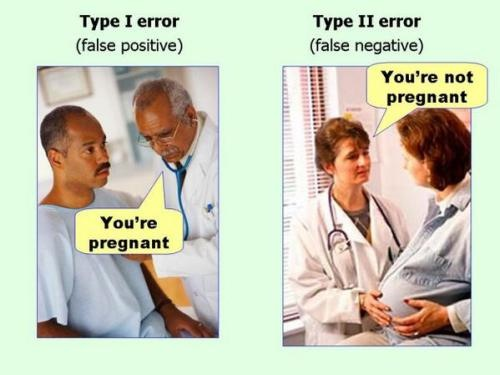

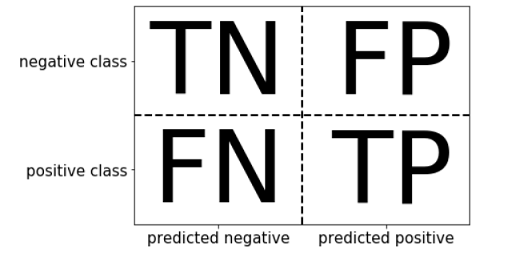

#### Modellen vergelijken a.h.v. hun confusion matrix

Welk model zou je preferen ?

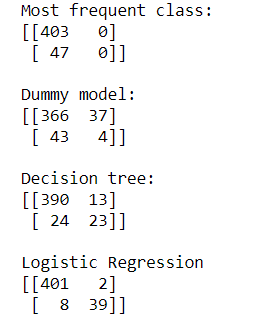

###### Relatie met  accuracy
\begin{equation}
\text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}
\end{equation}

##### Precision, recall en f-score

beperk het aantal valse positieven : verhoog precision

\begin{equation}
\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
\end{equation}


beperk het aantal valse negatieven : verhoog recall (ook sensitivity genoemd)

\begin{equation}
\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
\end{equation}

balanceer de trade-off tussen precision en recall: 

\begin{equation}
\text{F-score} = 2 \cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}
\end{equation}

Al deze scores zijn terug te vinden in [sklearn.metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)

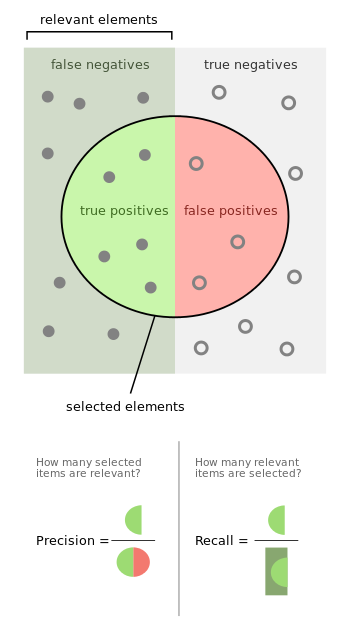

### De AUC-ROC curve

Deze curve vertelt hoe goed een model een onderscheid kan maken tussen klassen. 
Hoe hoger de AUC (area under the curve) hoe beter het model klassen kan onderscheiden.

> De ROC curve is een plot waarbij de TPR (true positive rate = recall) uitgezet wordt t.o.v. de FPR (false positive rate)

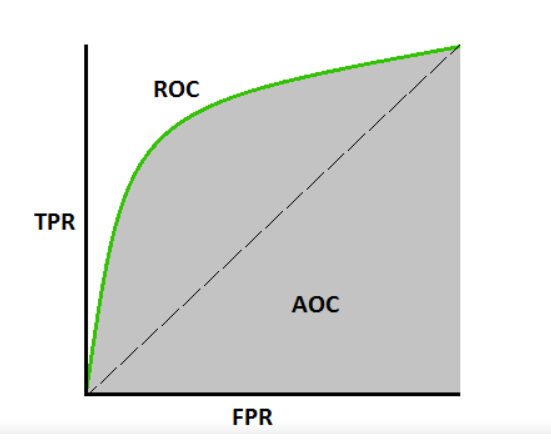

Een model dat een classificatieprobleem geleerd heeft zal voor elk datapunt steeds een threshold uitrekenen waarmee het kan beslissen of een datapunt positief of negatief is. We kunnen deze probabiliteiten testen op een validatieset en voor alle datapunten plotten we de voorspelde kans (x-as) (getal tussen 0 en 1) met de juiste kleur volgens positief of negatief. De y-as bevat een aantal (histogram). Op deze manier verkrijgen we de verdeling van de echte negatieve gevallen en de verdeling van de echte positieve gevallen in de validatieset. In onderstaande situatie blijkt dat alles boven $0.5$ werkelijk positief is. Het model kan dus perfect de 2 klassen onderscheiden.


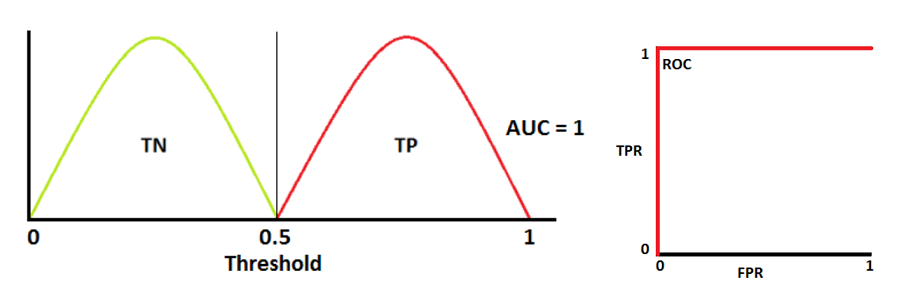

meestal overlappen die verdelingen echter: in onderstaande bijvoorbeeld zijn er behoorlijk wat datapunten waarvoor het model een probabiliteit van 0.5 berekende, maar de helft daarvan bleek positief en de andere helft negatief. Door de threshold op een positive klassificatie te verhogen naar 0.7 verkleint het aantal FP, maar vergroot het aantal FN en omgekeerd wanneer we de threshold zouden verlagen naar $0.3$. De ROC curve ontstaat door elke threshold te bekijken en telkens de TPR uit te zetten t.o.v. de FPR. Merk op een accuracy wordt steeds berekend voor 1 threshold waarde ($0.5$)

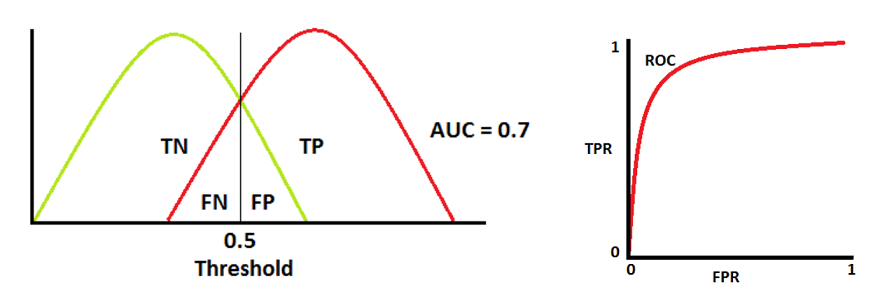


De keuze voor een treshold van $0.6$ zal hier een de TPR redelijk houden terwijl de FPR toch $0$ blijft 

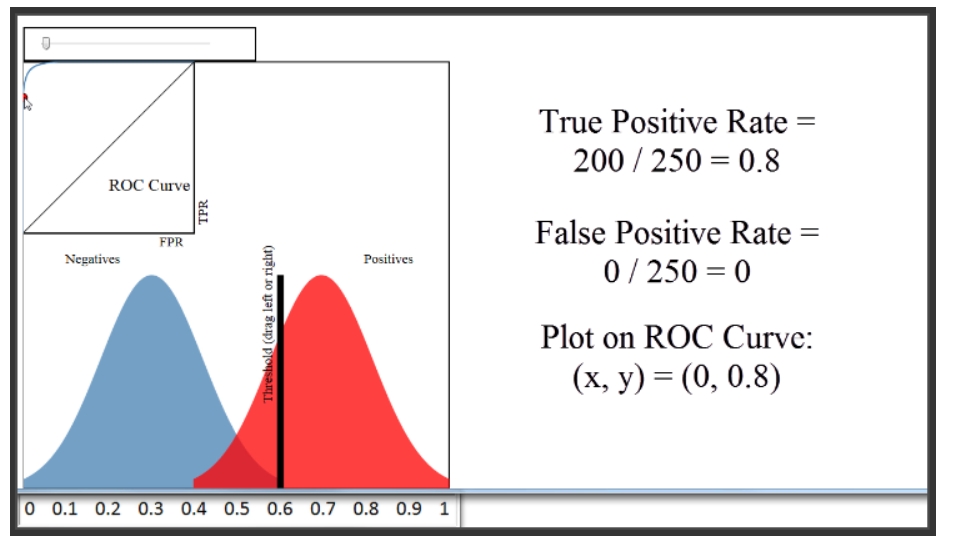

### Samengevat : 

Doel : generalizatie vermogen van het model verbeteren op reële data. 
    
- 1 test set gebruiken om accuracy te berekenen is erg beperkt 
    - cross-validatie en varianten geven je betere accuracy voorspelling maar is uiteraard rekenintensief
    
- parametertuning en gridsearch technieken helpen om generalizatievermogen te verhogen, 
  let wel dat je hierbij de testset niet gaat overfitten :
        - maak gebruik van een validatieset
        - doe de combinatie van gridsearch / cross-validatie (opnieuw : rekenintensief!)
        


### Samengevat : 


- Accuracy is niet altijd de betere metriek om te gebruiken op reële data !
  In realiteit :
    - data is niet gebalanceerd
    - onderliggende distributies van de data meestal niet zo smooth
    - andere metrieken kunnen soms beter bevatten wat je in realiteit wenst : 
        - in geval van binaire classificatie : 
            - recall, precisicion, F-score
            - De ROC curve en AUC metriek vormen een maat voor de probabiliteit dat een classifier 
             een random gekozen positief voorbeeld een hogere kans zal geven op positive classificatie 
             dan een random gekozen negatief voorbeeld.

    
In python : gebruik [de scoring parameter](https://scikit-learn.org/stable/modules/model_evaluation.html) om de metriek te wijzigen van accuracy naar bvb AUC
    

### Tutorials : 

- https://machinelearningmastery.com/k-fold-cross-validation/
- Understanding confusion matrix : https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62
- ROC curves and Area Under the Curve explained https://www.dataschool.io/roc-curves-and-auc-explained/
- Understanding AUC - ROC Curve
 https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5